# Run Function Threshold Power (rFTPw) Measurement

The notebook contains the code to calculate rFTPw based on [Run with Power book by Jim Vance](https://www.amazon.com/Run-Power-Complete-Meters-Running/dp/1937715434)

## What is rFTPw power?

rFTPw, similar to FTP in biking, is the critical amount of power that runner can output in **60 minutes** (unlike Stryd that uses critical power which is a 40 minutes interval). This measurement will be the anchor for runner to estimate their training load in their runs.

## 📚 Import Libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys

_path = os.getcwd()
while "run_with_data" not in os.listdir(_path):
    _path = os.path.dirname(_path)
sys.path.append(_path)

In [2]:
from typing import Dict, List, Union, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from tqdm.auto import tqdm

from run_with_data.client.garmin import GarminClient
from run_with_data.utils import get_power_indices, get_metric_index, split_df
from run_with_data.schema.run_activity import RunActivity
from run_with_data.schema.run_metric import PaceMinPerKm
from run_with_data.style import apply_brand_style, PRIMARY_COLOR, SECONDARY_COLOR

apply_brand_style()

In [3]:
# load .env
load_dotenv()

True

## 🤖 Initialize client

In [4]:
# setup your Garmin ID here
# or config in .env file
# os.environ["GARMIN_EMAIL"] = "your.email@example.com"
# os.environ["GARMIN_PASSWORD"] = "your_password"

In [5]:
# setup client
client = GarminClient()

## 🏃 Load Runs

Let's start with loading all activities

In [6]:
# get all activities
activities = client.get_run_activities(total=-1) # -1 means get all runs

In [7]:
print(f"Total {len(activities)} runs found")

Total 388 runs found


In the book, there are two ways to estimate rFTPw:

**1. 3/9 Test**

- warm up 15 minutes
- 3 minutes run all-out
- rest 5-minute walk, 10 minute very easy jog, 5-minute walk, 5-minute easy jog
- 9 minutes run all-out
- cool down

Add average 3-minute run power with 9-minute average run power and divide by 2. Then multiply the result by 0.9.

$$
\text{rFTPw}_{\text{3/9test}} = 0.9 *\frac12 [\frac{1}{|T_\text{3-min Interval}|}\Sigma_{t \in T_\text{3-min Interval}} p_t + \frac{1}{|T_\text{9-min Interval}|}\Sigma_{t \in T_\text{39min Interval}} p_t]
$$

**2. 30 minutes time trial**
 
Run 30 minutes all-out. rFTPw is calculated using averaged run power in the last 20 minutes:

$$
\text{rFTPw}_{\text{30-min time trial}} = \frac{1}{|T_\text{last 20 minute}|}\Sigma_{t \in T_\text{last 20 minute}}p_t
$$

For this case, we'll focus more on 30 minutes time trial since we can get more historical run that match the 30-minutes criteria. Let's start with filtering the runs that could be used to calculate rFTPw.

## 🔍 Filtering runs

We can classify runs that matched our criteria by just loading any run that satisfy with the following criteria:
1. The run should be continuous and at least 30 minutes long and is less than 35 minutes.
2. The average heart rate of the split should be above 170 to consider an all-out effort.
3. Must contains Stryd running data since it's probably the most accurate one so far.

With these two criterias, we can filter out the run that can be used to calculate the rFTPw.

In [8]:
pd.set_option('future.no_silent_downcasting', True)


def get_potential_splits(
    activities: List[RunActivity], 
    client: GarminClient,
    min_max_effort_hr: int = 165, 
    run_dur: Tuple[int, int] = (28, 32),
) -> List[Dict[str, Union[RunActivity, pd.DataFrame]]]:
    min_dur, max_dur = run_dur
    potential_splits = []
    
    for activity in tqdm(activities, desc="Screening runs"):
        activity.load_details(client)
        # skip non-stryd runs
        power_metrics = get_power_indices(activity)
        if power_metrics["stryd"] is None:
            continue

        df = activity.to_df(client, resample="1s")
        for split in split_df(df):
            duration = (split.index.max() - split.index.min()).total_seconds()
            # skip if too short or too long
            if not min_dur*60 <= duration <= max_dur*60:
                continue
    
            if split["Heart Rate"].mean() < min_max_effort_hr:
                continue
    
            potential_splits.append({
                "activity": activity,
                "split": split
            })
    return potential_splits

In [9]:
MIN_MAX_EFFORT_HR = 165
MIN_RUN_DUR, MAX_RUN_DUR = 28, 32 # minutes

potential_splits = get_potential_splits(
    activities=activities, 
    client=client,
    min_max_effort_hr=MIN_MAX_EFFORT_HR,
    run_dur=(MIN_RUN_DUR, MAX_RUN_DUR)
)

Screening runs:   0%|          | 0/388 [00:00<?, ?it/s]

In [10]:
print(f"Total {len(potential_splits)} splits from {len(set([_s["activity"].activity_id for _s in potential_splits]))} runs found!")

Total 4 splits from 4 runs found!


## 🕵️  Inspecting Runs

Now that we have 4 runs left, let's address the following questions:
- How difference is the power used for each run?
- How much do heart rate differs in each run?
- How reliable is each run to be used to calculate rFTPw?

In [11]:
for _s in potential_splits:
    print(_s["activity"].url)

https://connect.garmin.com/modern/activity/18035502890
https://connect.garmin.com/modern/activity/17909485129
https://connect.garmin.com/modern/activity/17212861160
https://connect.garmin.com/modern/activity/14542154156


Let's look at the power plot for each run

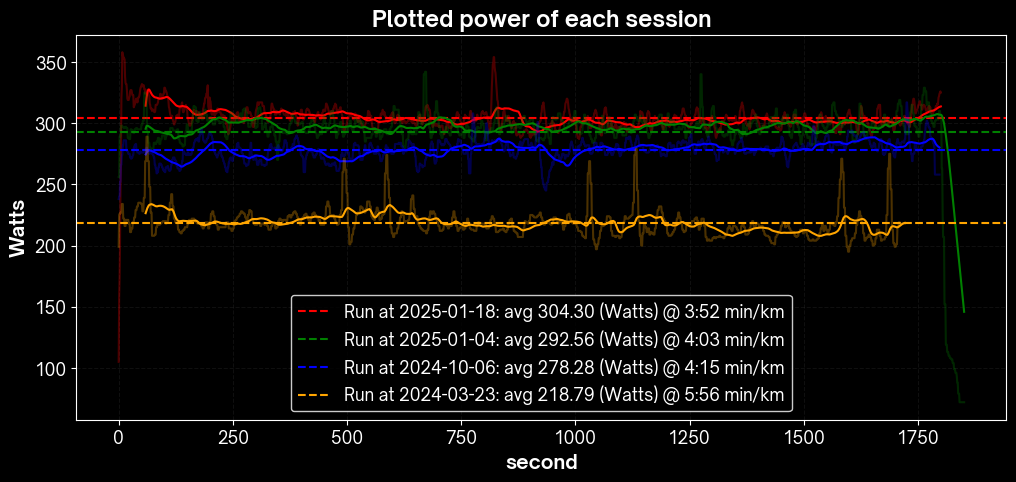

In [12]:
colors = ["red", "green", "blue", "orange"]
color_iter = iter(colors)

plt.figure(figsize=(12, 5))
for split in potential_splits:
    c = next(color_iter)
    a = split["activity"]
    df = split["split"]

    avg_pace = PaceMinPerKm.from_mps(df["Speed"].mean())

    plt.plot(
        df["Power - StrydZones - Running Power Zones"].values, 
        # label=a.start_time.strftime("%Y-%m-%d"), 
        color=c,
        alpha=0.3
    )
    plt.plot(
        df["Power - StrydZones - Running Power Zones"].rolling(window=60).mean().values, 
        # label=a.start_time.strftime("%Y-%m-%d"),
        color=c,
    )
    plt.axhline(
        df["Power - StrydZones - Running Power Zones"].mean(),
        color=c,
        linestyle="--",
        label=f"Run at {a.start_time.strftime("%Y-%m-%d")}: avg {df['Power - StrydZones - Running Power Zones'].mean():.2f} (Watts) @ {avg_pace.minute:01d}:{avg_pace.second:02d} min/km"
    )
plt.title("Plotted power of each session")
plt.ylabel("Watts")
plt.xlabel("second")
plt.legend()
plt.show()

Overall looks as expected! We can see gradual improvement over time!

Let's looks at heart rate as well

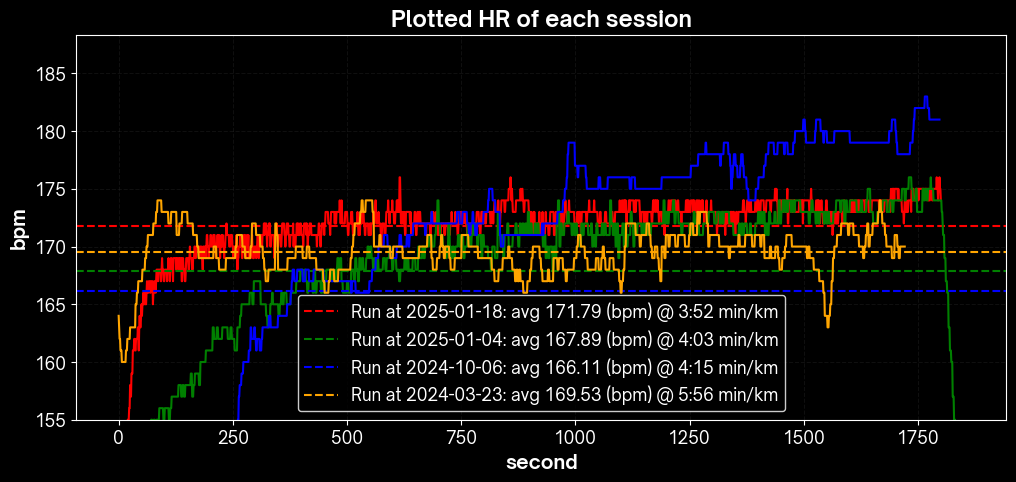

In [13]:
colors = ["red", "green", "blue", "orange"]
color_iter = iter(colors)

plt.figure(figsize=(12, 5))
for split in potential_splits:
    c = next(color_iter)
    a = split["activity"]
    df = split["split"]

    avg_pace = PaceMinPerKm.from_mps(df["Speed"].mean())

    plt.plot(
        df["Heart Rate"].values, 
        # label=a.start_time.strftime("%Y-%m-%d"), 
        color=c,
    )
    plt.axhline(
        df["Heart Rate"].mean(),
        color=c,
        linestyle="--",
        label=f"Run at {a.start_time.strftime("%Y-%m-%d")}: avg {df['Heart Rate'].mean():.2f} (bpm) @ {avg_pace.minute:01d}:{avg_pace.second:02d} min/km"
    )
plt.ylim(bottom=155)
plt.title("Plotted HR of each session")
plt.ylabel("bpm")
plt.xlabel("second")
plt.legend()
plt.show()

Let's look at split distance compared to total run distance. This will allow us to see how reliable our run used to calculate the test is.

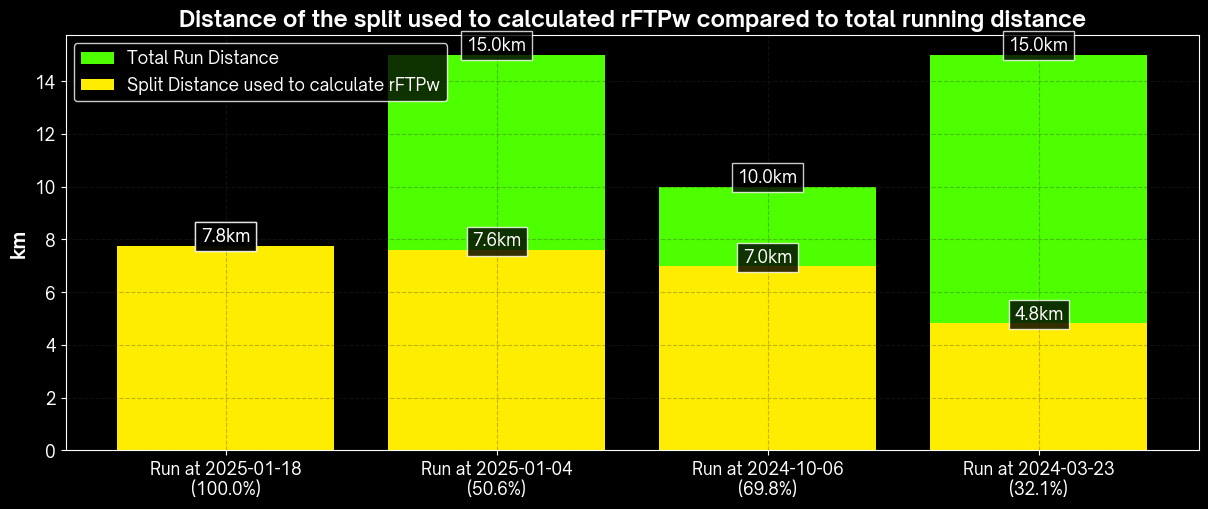

In [14]:
total_running_dist = []
split_dist = []
x = []
for split in potential_splits:
    a = split["activity"]
    df = split["split"]
    run_distance = a.to_df(client)["Total Distance"].max() / 1000
    split_distance_covered = (df["Total Distance"].max() - df["Total Distance"].min()) / 1000
    total_running_dist.append(run_distance)
    split_dist.append(split_distance_covered)
    x.append(f"Run at {a.start_time.strftime('%Y-%m-%d')}")

plt.figure(figsize=(12, 5))

# Calculate percentages
percentages = [split/total * 100 for split, total in zip(split_dist, total_running_dist)]

# Create x-labels with percentages
x_with_pct = [f"{date}\n({pct:.1f}%)" for date, pct in zip(x, percentages)]

# Plot the bars with labels for legend
bars1 = plt.bar(x_with_pct, total_running_dist, label='Total Run Distance')
bars2 = plt.bar(x_with_pct, split_dist, label='Split Distance used to calculate rFTPw')

# Add value labels on top of each bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f'{height:.1f}km',
            ha='center',
            va='bottom',
            color='white',  # Change text color to white for contrast
            bbox=dict(facecolor='black', alpha=0.8)  # Black box background
        )

# Add legend
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.title("Distance of the split used to calculated rFTPw compared to total running distance")
plt.ylabel("km")

plt.show()

Although percentage of split distance can be used to measure accuracy of the rFTPw, we need to be cautious since those addition distance could be a very easy run. Let's inspect more into these splits.

In [15]:
for split in potential_splits:
    a = split["activity"]
    rftpw_split = split["split"]

    run_df = a.to_df(client, resample="1s")

    pre_split_df = run_df.loc[[i for i in run_df.index if i < rftpw_split.index.min()]]
    post_split_df = run_df.loc[[i for i in run_df.index if i > rftpw_split.index.max()]]

    print(f"[ 🏃 Run @ {a.start_time.strftime("%Y-%m-%d")} ]")
    print(a.url)

    if len(pre_split_df) > 0:
        warmup_pace = PaceMinPerKm.from_mps(pre_split_df["Speed"].mean()).__repr__()
        warmup_dist = (pre_split_df["Total Distance"].max() - pre_split_df["Total Distance"].min())/1000
        print(f"warmup avg pace: {warmup_pace} - {warmup_dist:.2f} km")
    else:
        print("No warmup!")
        
    print("rFTPw split pace:", PaceMinPerKm.from_mps(rftpw_split["Speed"].mean()).__repr__())
    
    if len(post_split_df) > 0:
        cooldown_pace = PaceMinPerKm.from_mps(post_split_df["Speed"].mean()).__repr__()
        cooldown_dist = (post_split_df["Total Distance"].max() - post_split_df["Total Distance"].min())/1000
        print(f"cooldown avg pace: {cooldown_pace} - {cooldown_dist:.2f} km")
    else:
        print("No cooldown!")

    print("="*5)

[ 🏃 Run @ 2025-01-18 ]
https://connect.garmin.com/modern/activity/18035502890
No warmup!
rFTPw split pace: 03:52 min/km
No cooldown!
=====
[ 🏃 Run @ 2025-01-04 ]
https://connect.garmin.com/modern/activity/17909485129
warmup avg pace: 06:48 min/km - 3.03 km
rFTPw split pace: 04:03 min/km
cooldown avg pace: 07:30 min/km - 15.00 km
=====
[ 🏃 Run @ 2024-10-06 ]
https://connect.garmin.com/modern/activity/17212861160
warmup avg pace: 10:01 min/km - 0.49 km
rFTPw split pace: 04:15 min/km
cooldown avg pace: 05:02 min/km - 10.00 km
=====
[ 🏃 Run @ 2024-03-23 ]
https://connect.garmin.com/modern/activity/14542154156
warmup avg pace: 05:20 min/km - 2.78 km
rFTPw split pace: 05:56 min/km
cooldown avg pace: 08:00 min/km - 15.00 km
=====


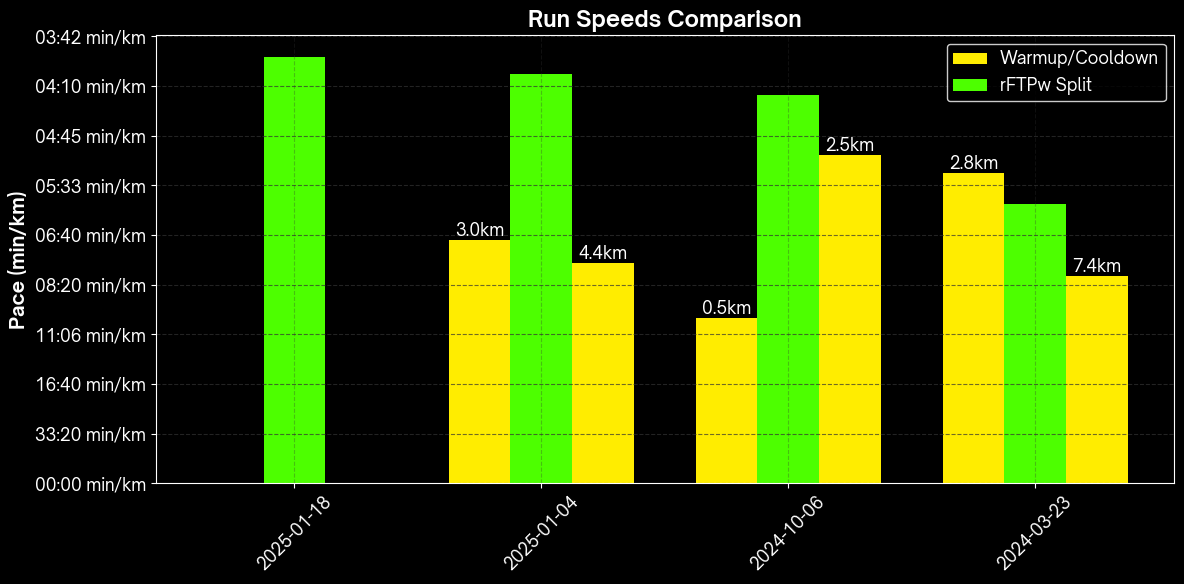

In [16]:
# Lists to store data
dates = []
warmup_speeds = []
rftpw_speeds = []
cooldown_speeds = []
pre_distances = []    # New list for warmup distances
post_distances = []   # New list for cooldown distances

# Process each run
for split in potential_splits:
    a = split["activity"]
    rftpw_split = split["split"]
    run_df = a.to_df(client, resample="1s")
    
    # Get date for x-axis label
    dates.append(a.start_time.strftime("%Y-%m-%d"))
    
    # Calculate speeds for each segment
    pre_split_df = run_df.loc[[i for i in run_df.index if i < rftpw_split.index.min()]]
    post_split_df = run_df.loc[[i for i in run_df.index if i > rftpw_split.index.max()]]
    # hack to fix bug
    post_split_df["Total Distance"] = post_split_df["Total Distance"].replace(0., np.nan).bfill()
    
    # Calculate distances
    pre_dist = (pre_split_df["Total Distance"].max() - pre_split_df["Total Distance"].min()) / 1000
    post_dist = (post_split_df["Total Distance"].max() - post_split_df["Total Distance"].min()) / 1000
    pre_distances.append(pre_dist)
    post_distances.append(post_dist)
    
    # Store speeds
    warmup_speeds.append(pre_split_df["Speed"].mean() if len(pre_split_df) > 0 else 0)
    rftpw_speeds.append(rftpw_split["Speed"].mean())
    cooldown_speeds.append(post_split_df["Speed"].mean() if len(post_split_df) > 0 else 0)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))
# Set width of bars and positions of the bars
width = 0.25
x = np.arange(len(dates))

# Create bars
warmup_bars = ax.bar(x - width, warmup_speeds, width, label='Warmup/Cooldown', color=SECONDARY_COLOR)
rftpw_bars = ax.bar(x, rftpw_speeds, width, label='rFTPw Split', color=PRIMARY_COLOR)
cooldown_bars = ax.bar(x + width, cooldown_speeds, width, color=SECONDARY_COLOR)

# Add distance annotations
for i, (pre_dist, post_dist) in enumerate(zip(pre_distances, post_distances)):
    if pre_dist > 0:
        ax.text(x[i] - width, warmup_speeds[i], f'{pre_dist:.1f}km', 
                ha='center', va='bottom')
    if post_dist > 0:
        ax.text(x[i] + width, cooldown_speeds[i], f'{post_dist:.1f}km', 
                ha='center', va='bottom')

# Customize the plot
ax.set_ylabel('Speed (m/s)')
ax.set_title('Run Speeds Comparison')
ax.set_xticks(x)
ax.set_xticklabels(dates, rotation=45)
ax.legend()
# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Get current y-axis limits in m/s
y_min, y_max = ax.get_ylim()
# Create pace tick positions (m/s)
pace_ticks = np.arange(y_min, y_max, 0.5)  # Adjust range as needed for your data
# Convert speed ticks to pace strings
pace_labels = [PaceMinPerKm.from_mps(speed).__repr__() for speed in pace_ticks]
# Update y-axis
ax.set_yticks(pace_ticks)
ax.set_yticklabels(pace_labels)
ax.set_ylabel('Pace (min/km)')

# Adjust layout to prevent label cutoff and make room for annotations
plt.tight_layout()
plt.show()

The `2024-03-23` run looks a bit skeptical since warmup was 3k and is faster than the all-out effort pace. So I guess that run is the least reliable run to be used to calculate rFTPw.

## ⚡ Calculate rFTPw

Now it's time to calculate our rFTPw using our runs!

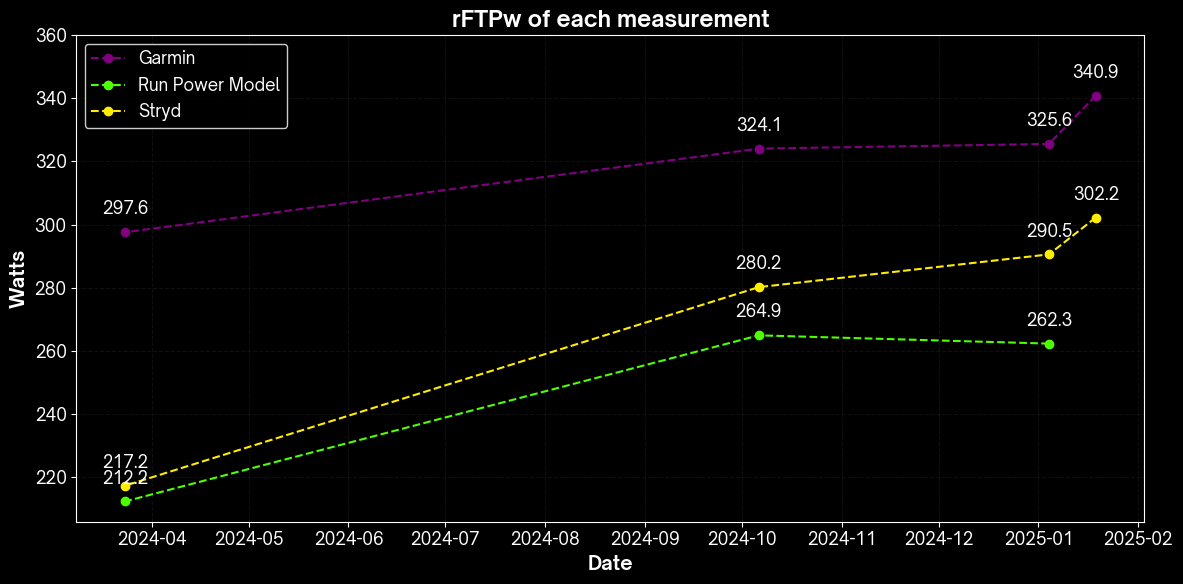

In [17]:
measured_date = []
rftpw = {
    "stryd": [],
    "garmin": [],
    "run power model": []
}
for split in potential_splits:
    a = split["activity"]
    df = split["split"]
    date = a.start_time
    garmin_rftpw = df.iloc[-20*60:]["Power - Garmin"].mean()
    rpm_rftpw = df.iloc[-20*60:]["Running Power"].mean() if "Running Power" in df.columns else None
    stryd_rftpw = df.iloc[-20*60:]["Power - StrydZones - Running Power Zones"].mean()
    measured_date.append(date)
    rftpw["garmin"].append(garmin_rftpw)
    rftpw["run power model"].append(rpm_rftpw)
    rftpw["stryd"].append(stryd_rftpw)

plt.figure(figsize=(12, 6))

# Plot lines and markers
plt.plot(measured_date, rftpw["garmin"], color="purple", linestyle="--", marker="o", label="Garmin")
plt.plot(measured_date, rftpw["run power model"], color=PRIMARY_COLOR, linestyle="--", marker="o", label="Run Power Model")
plt.plot(measured_date, rftpw["stryd"], color=SECONDARY_COLOR, linestyle="--", marker="o", label="Stryd")

# Add value annotations
for date, value in zip(measured_date, rftpw["garmin"]):
    if not pd.isna(value):  # Check if value is not NaN
        plt.annotate(f'{value:.1f}', 
                    (date, value),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    va='bottom')

for date, value in zip(measured_date, rftpw["run power model"]):
    if not pd.isna(value):  # Check if value is not NaN
        plt.annotate(f'{value:.1f}', 
                    (date, value),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    va='bottom')

for date, value in zip(measured_date, rftpw["stryd"]):
    if not pd.isna(value):  # Check if value is not NaN
        plt.annotate(f'{value:.1f}', 
                    (date, value),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    va='bottom')

plt.xlabel("Date")
plt.ylabel("Watts")
plt.title("rFTPw of each measurement")
plt.legend()
plt.ylim(top=360)
# Adjust layout to prevent annotation cutoff
plt.tight_layout()
plt.show()